# Graph Based Segragation Index

Socio- Economic Data Retrived from:

http://www.ecuadorencifras.gob.ec/documentos/datos/Poblacion_y_Demografia/Censo_poblacion_y_vivienda_/bdd_nivel_manzana_censal/Spss/CPV2010M_SPSS_Azuay.zip

SPSS file processed in R. We use dwelling as our unit of analysis, all the data has been previously aggregated at this level

In [1]:
%load_ext autoreload
%autoreload 2
import multiplex_segregation as ms
from multiplex_segregation import np, pd, gpd, nx, ox
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import display, Markdown

## Configuration script

In [2]:
network_type = 'drive'                    #get walkable streets and paths (ignores directionality)
retain_all = False                       #retain all only largest connected component
crs_osm = {'init':'epsg:4326'}           #crs that osm uses
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'input_data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops'                    #the input file for all bus stop shaspes
allFiles = glob.glob('{}/{}/*.shp'.format(input_folder, busStop)) #list of all bus stop shapes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

### Read ShapeFiles and Reprojections

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))

busStop_list = []

for file_ in allFiles:
    lineNum = file_.split('linea_',1)[1].split('.')[0]
    df = gpd.read_file(file_)
    df['lineNum'] = int(lineNum)
    busStop_list.append(df)
busStopGPD = gpd.GeoDataFrame(pd.concat(busStop_list, ignore_index = True))

#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(output_path, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Download street network

Blocks define urban area, alpha shape is used to draw a boundary around multiple unconnected block geometries

Calculating Boundary with alpha = 0.004 ...


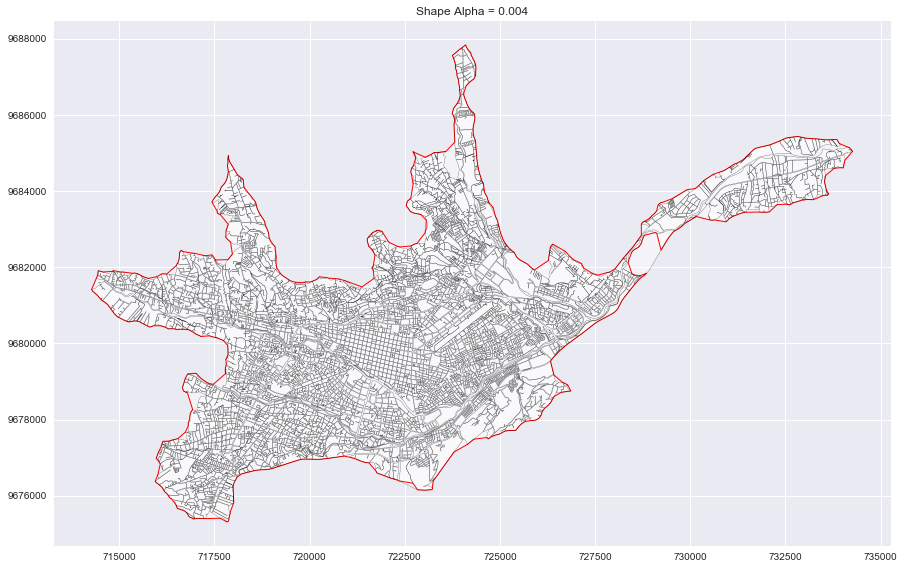

Calculating Boundary with alpha = 0.0035 ...


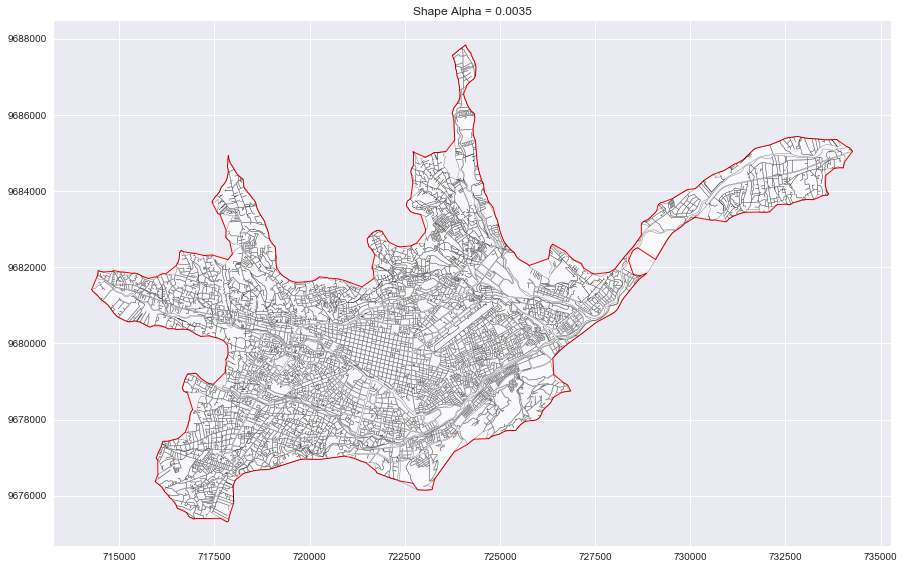

Calculating Boundary with alpha = 0.003 ...


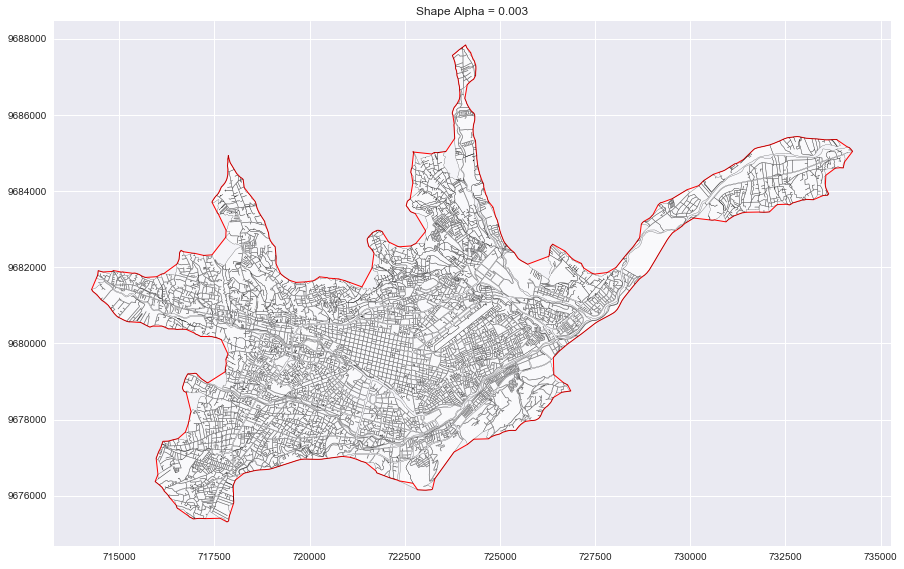

Calculating Boundary with alpha = 0.0025 ...


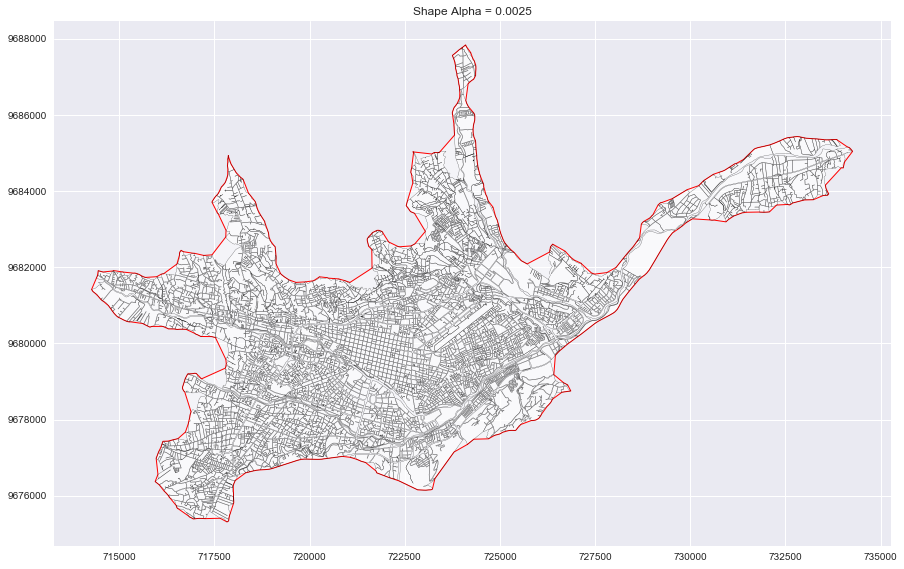

In [5]:
for i in range(4):
    alpha = 0.004 - (i*0.0005)
    temp = ms.boundary_from_areas(blocksGPD, alpha = alpha)
    base = temp.plot(color = 'white',edgecolor='red',linewidth=1, figsize = (15,10))
    base.set_title("Shape Alpha = {}".format(alpha))
    blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  ax = base)
    plt.show()

## Create Street Network
create time weighted graph to represent the street network using Block Geometry, Alpha Value = 0.0025 and a walking speed = 5km/h

In [5]:
street_network, area = ms.construct_street_graph(blocksGPD,
                                                crs_osm, 
                                                crs_utm,
                                                alpha = 0.0025,
                                                buffer_dist=200,
                                                speed = 5
                                               )

Generating geometry...
Calculating Boundary with alpha = 0.0025 ...
Generating street graph...


C:\Anaconda\lib\site-packages\osmnx\utils.py:268: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


Reprojecting street graph...
done!


In [7]:
#Save Road Network and Urban Area
print('Saving street graph and Urban Area')
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefile'.format('street_network'))
ox.save_graphml(street_network, folder = graphs_folder, filename = '{}/graph'.format('street_network'))
area.to_file('{}/area'.format(output_path))

Saving street graph and Urban Area


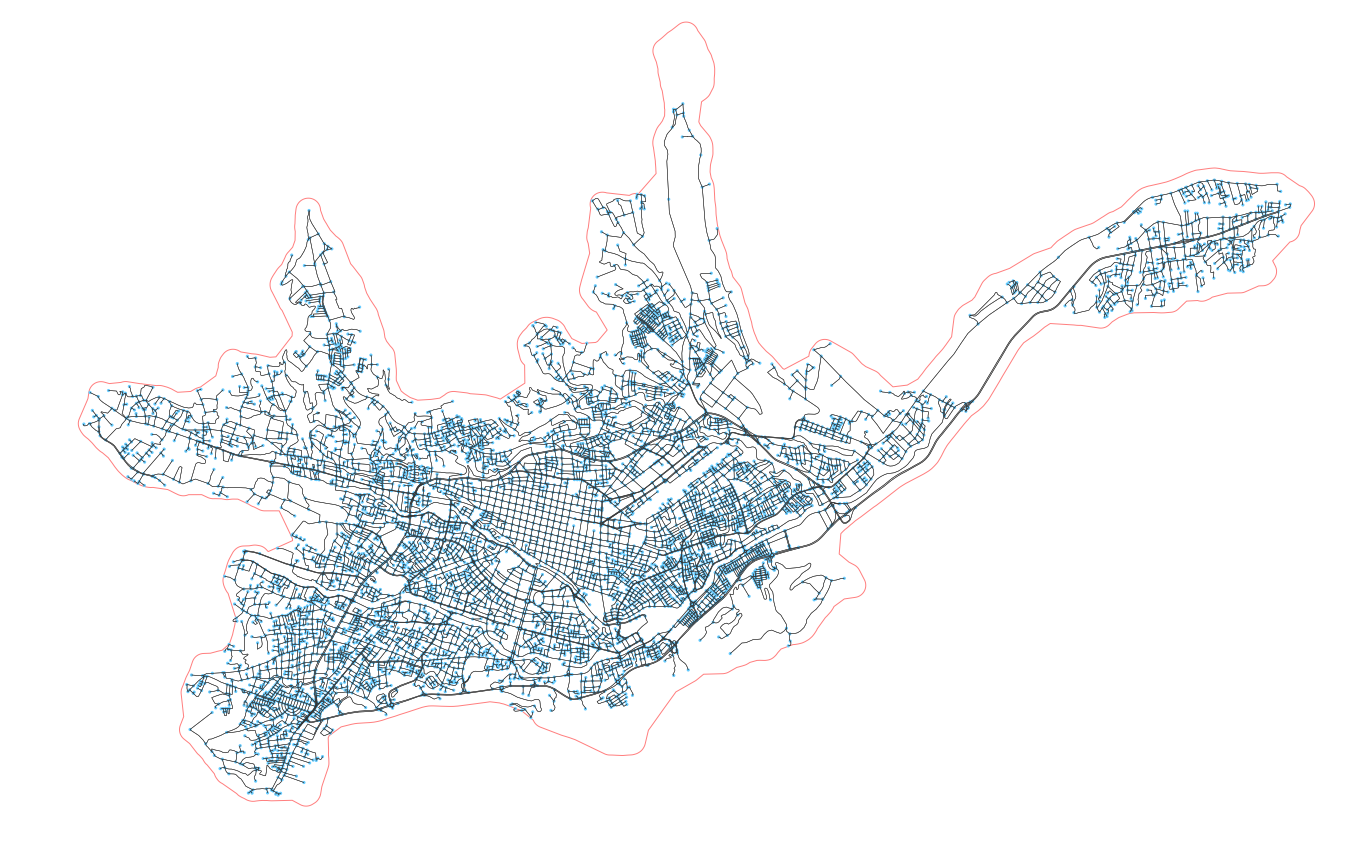

In [6]:
ms.plot_network(street_network, area)

## Get Road Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


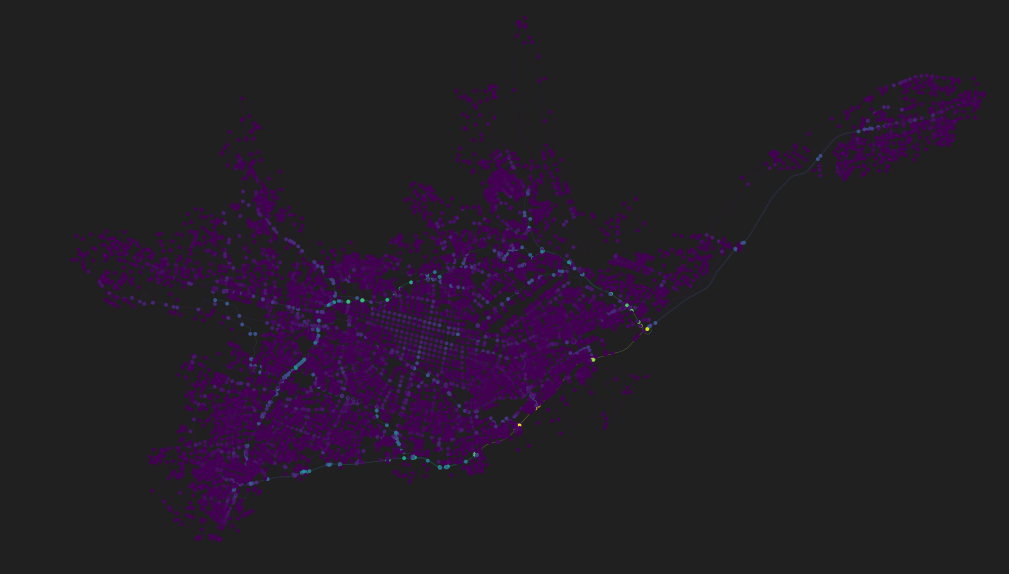

calculating measures for: Random Walk Betweenness


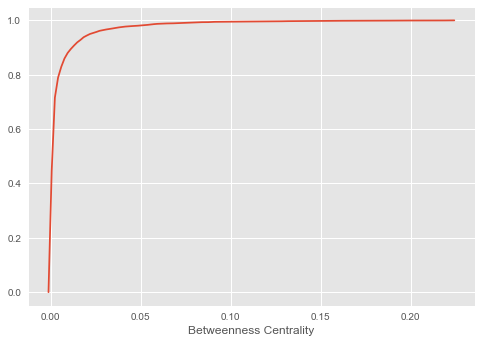

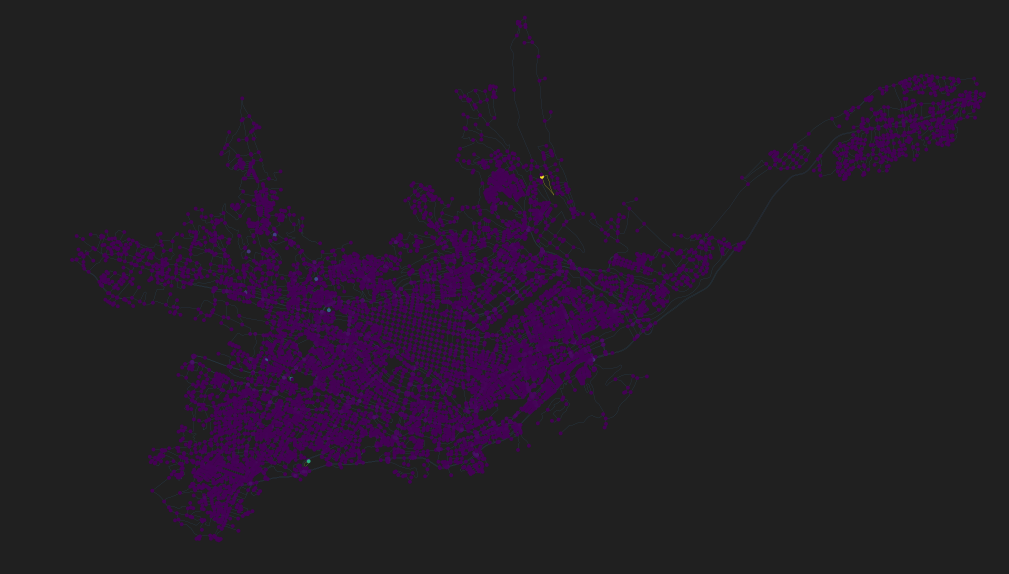

calculating measures for: Information Centrality


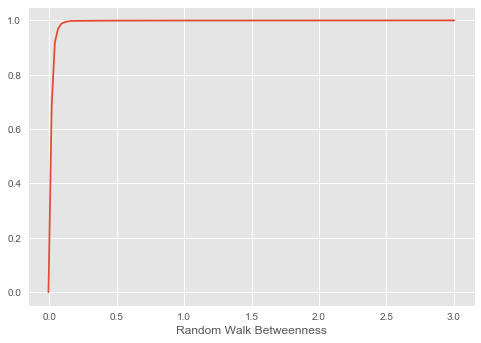

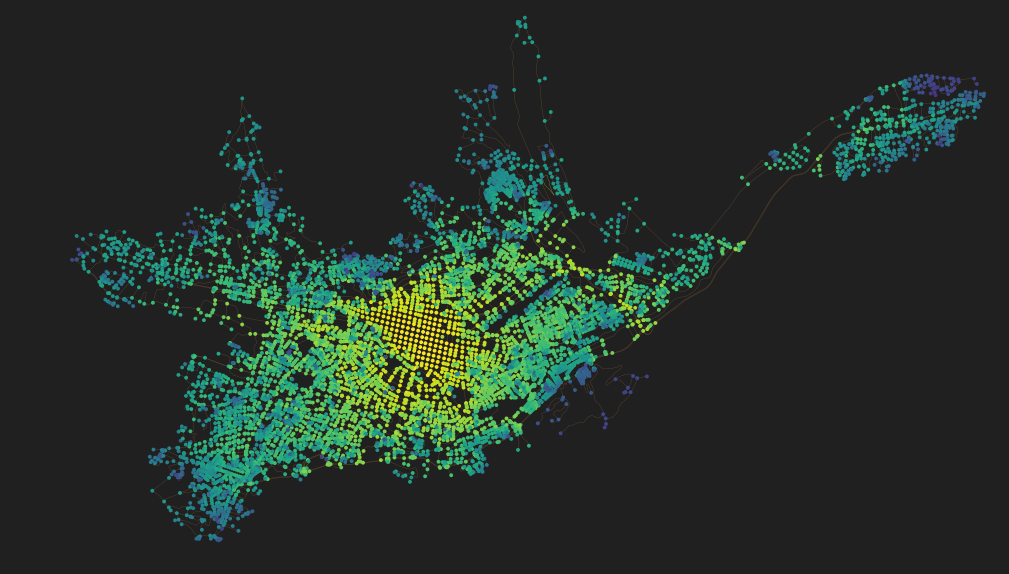

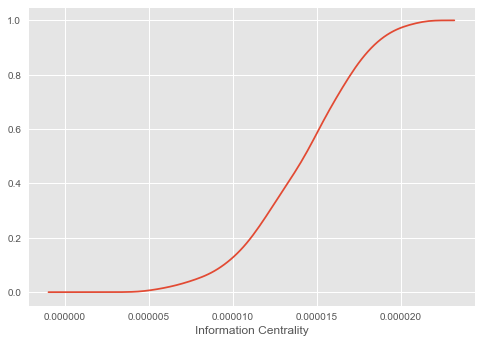

In [227]:
G = ms.network_stats(street_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('street_stats'))

## Create Bus Network Graph

plotting results for each line:


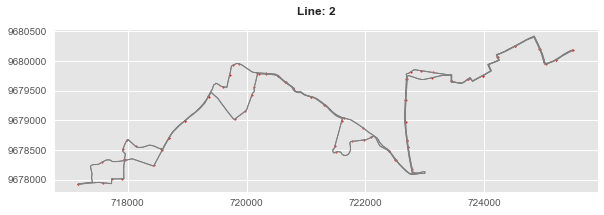

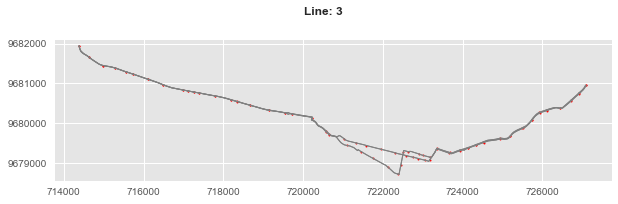

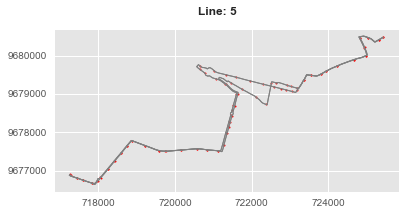

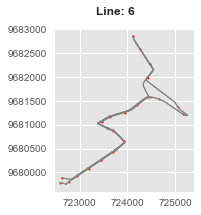

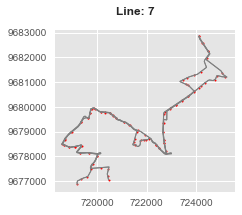

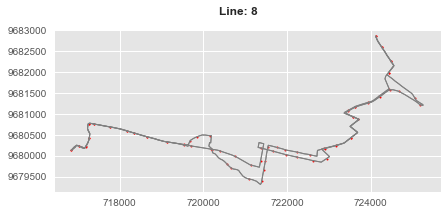

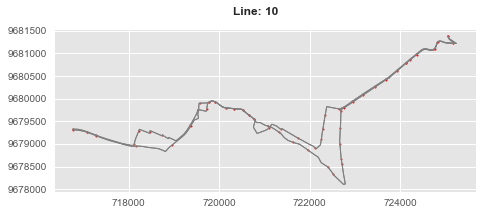

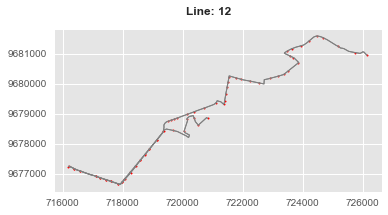

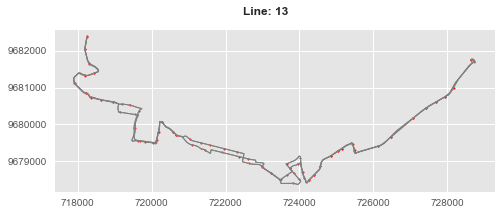

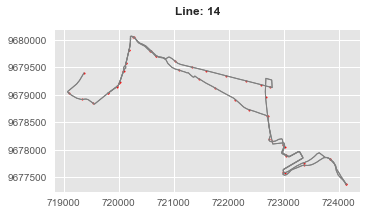

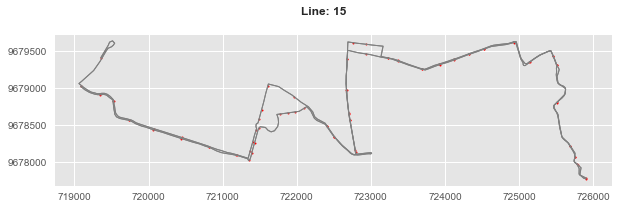

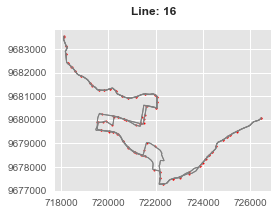

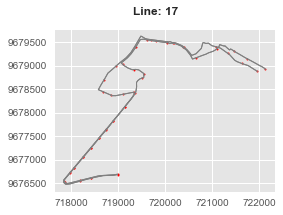

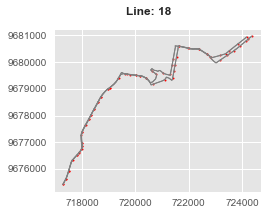

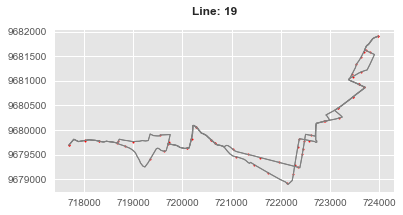

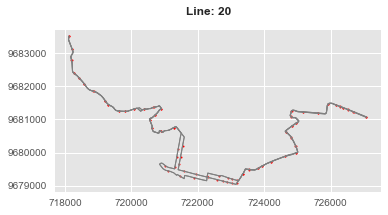

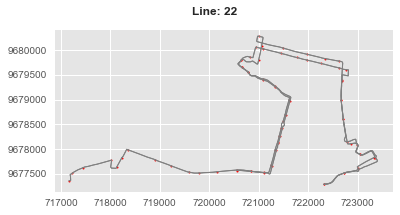

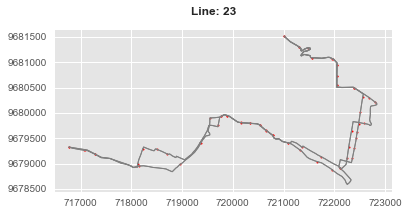

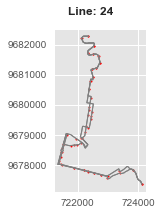

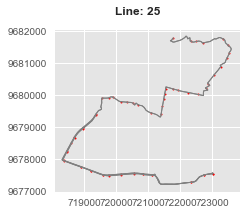

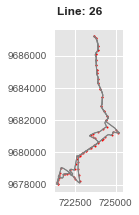

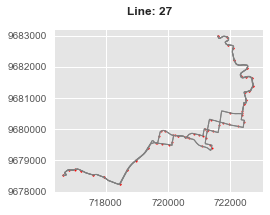

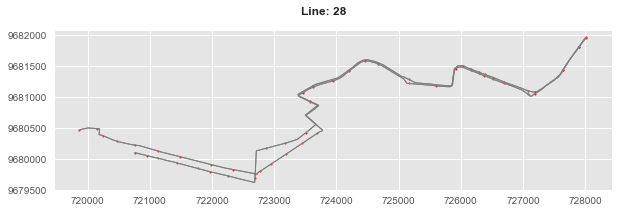

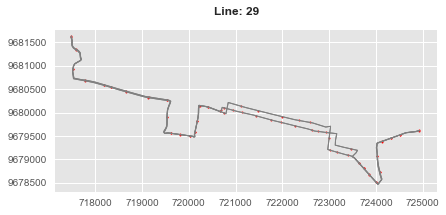

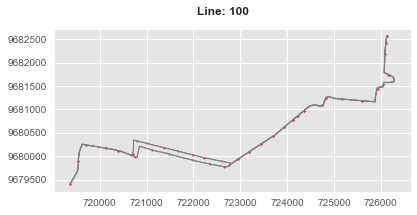

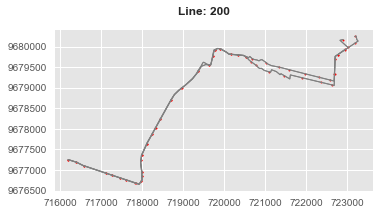

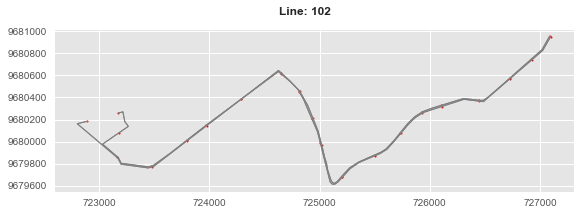

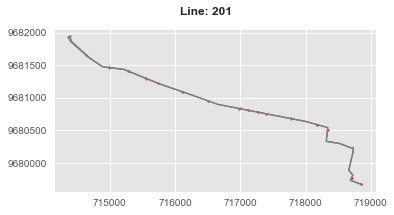

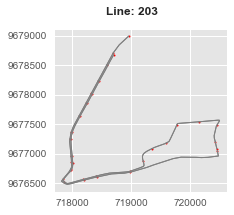

networkx.classes.multidigraph.MultiDiGraph

In [6]:
#create bus network
bus_network = ms.create_bus_network(busLineGPD, busStopGPD, area, speed = 30)
type(bus_network)
#plot bus network graph
# ox.save_graph_shapefile(bus_network, folder = graphs_folder, filename = '{}/shapefile'.format('bus_network'))
# ox.save_graphml(bus_network, folder = graphs_folder, filename = '{}/graph'.format('bus_network'))

[autoreload of multiplex_segregation failed: Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\IPython\extensions\autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Mateo Neira\Desktop\MscSMARTCITIES\dissertation\Scripts\multiplex_segregation.py", line 1238
    p = generate a ran
                 ^
SyntaxError: invalid syntax
]


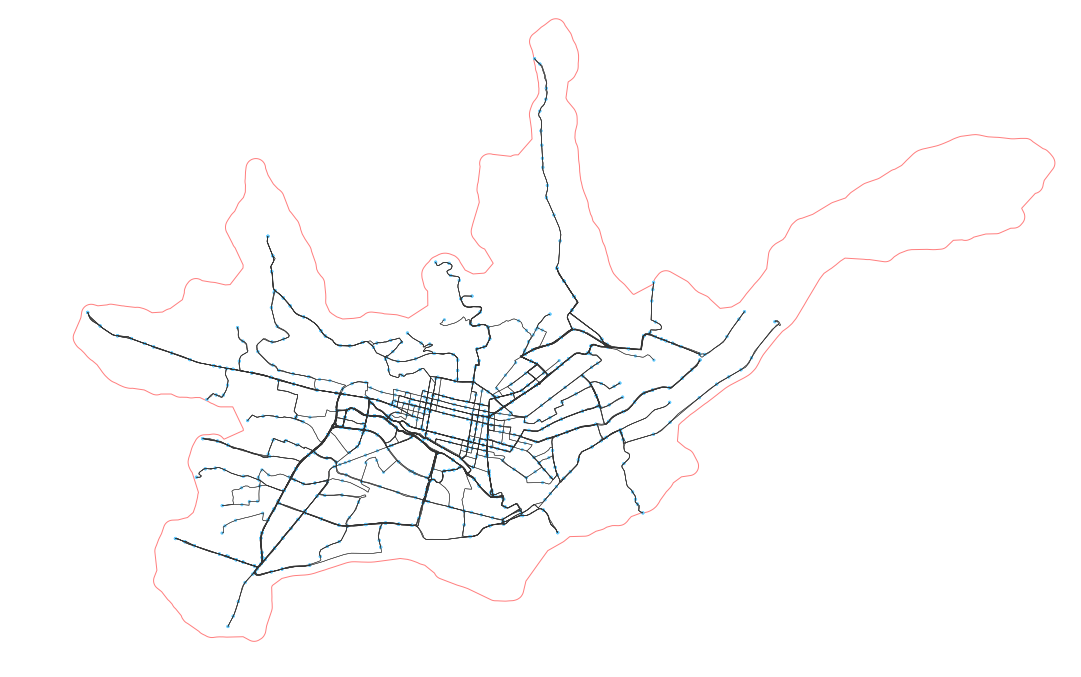

In [8]:
ms.plot_network(bus_network, area)

## Get Bus Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


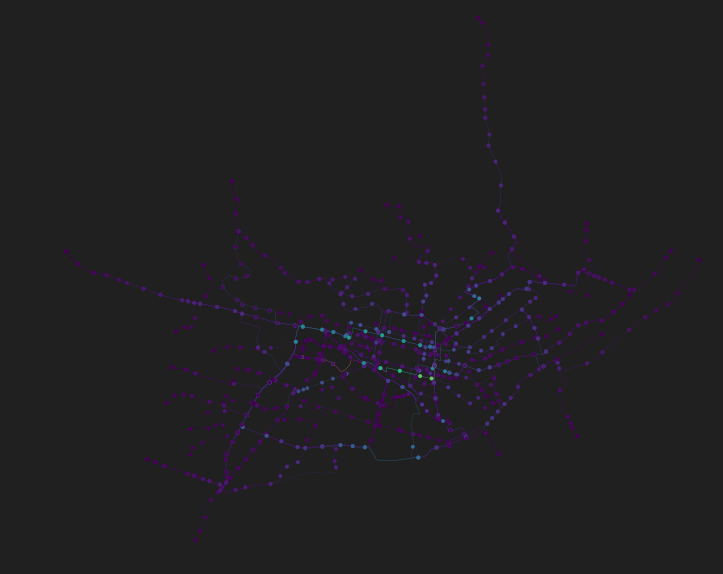

calculating measures for: Random Walk Betweenness


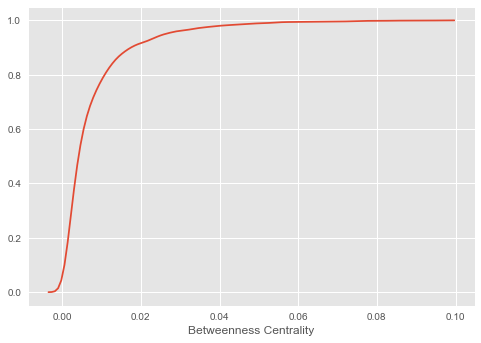

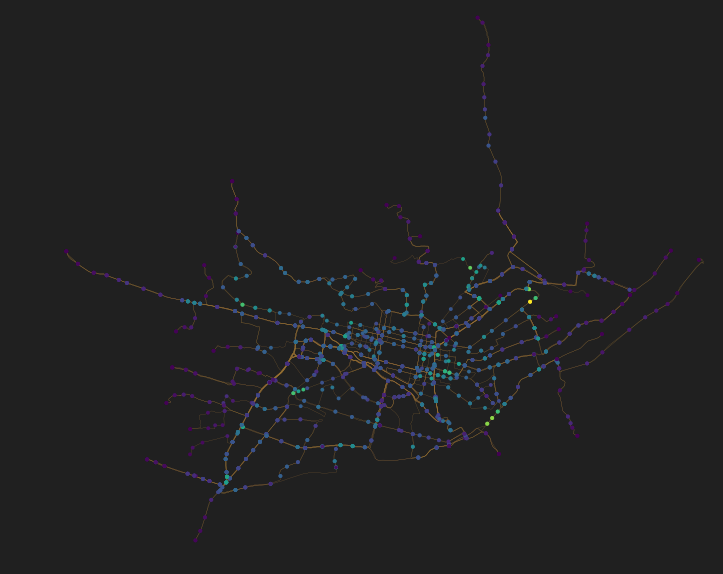

calculating measures for: Information Centrality


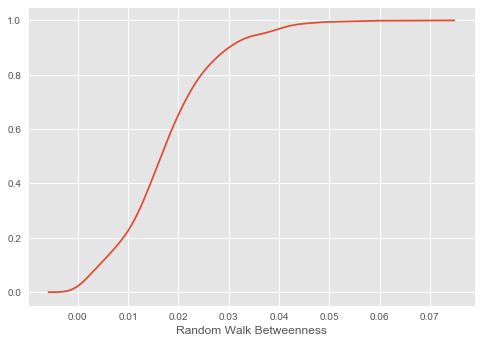

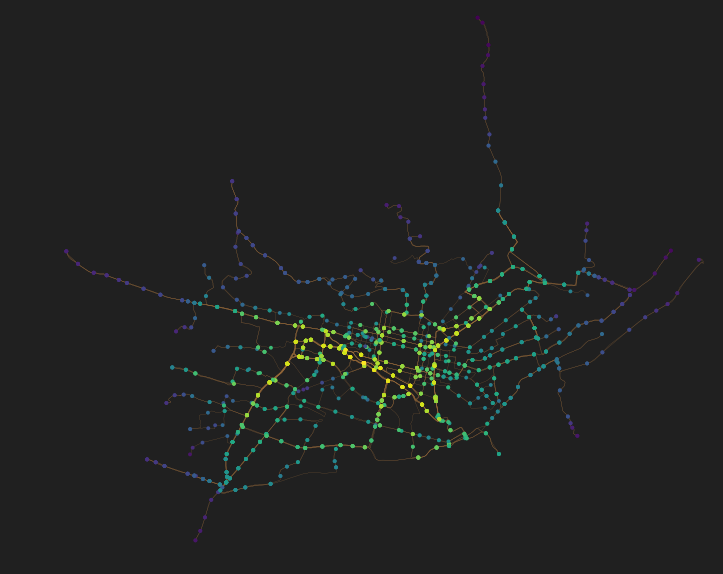

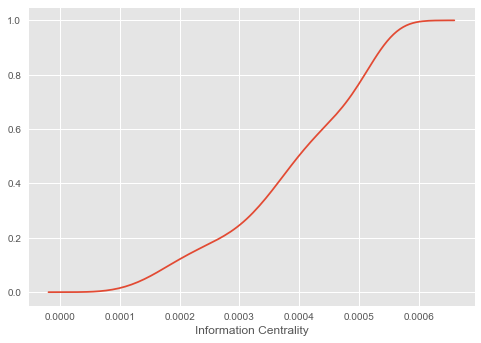

In [226]:
G = ms.network_stats(bus_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('bus_stats'))

## Create Tram Network Graph

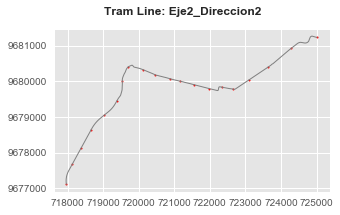

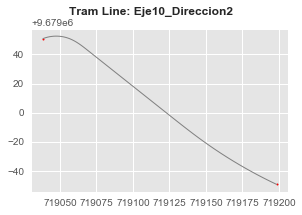

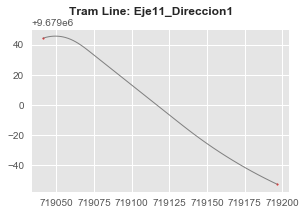

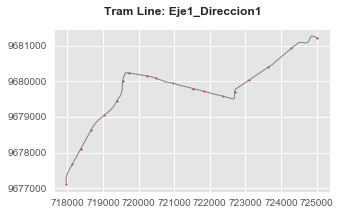

In [7]:
tram_network = ms.create_tram_network(tramLineGPD, tramStopGPD, area)
#plot bus network graph
# ox.save_graph_shapefile(tram_network, folder = graphs_folder, filename = '{}/shapefile'.format('tram_network'))
# ox.save_graphml(tram_network, folder = graphs_folder, filename = '{}/graph'.format('tram_network'))

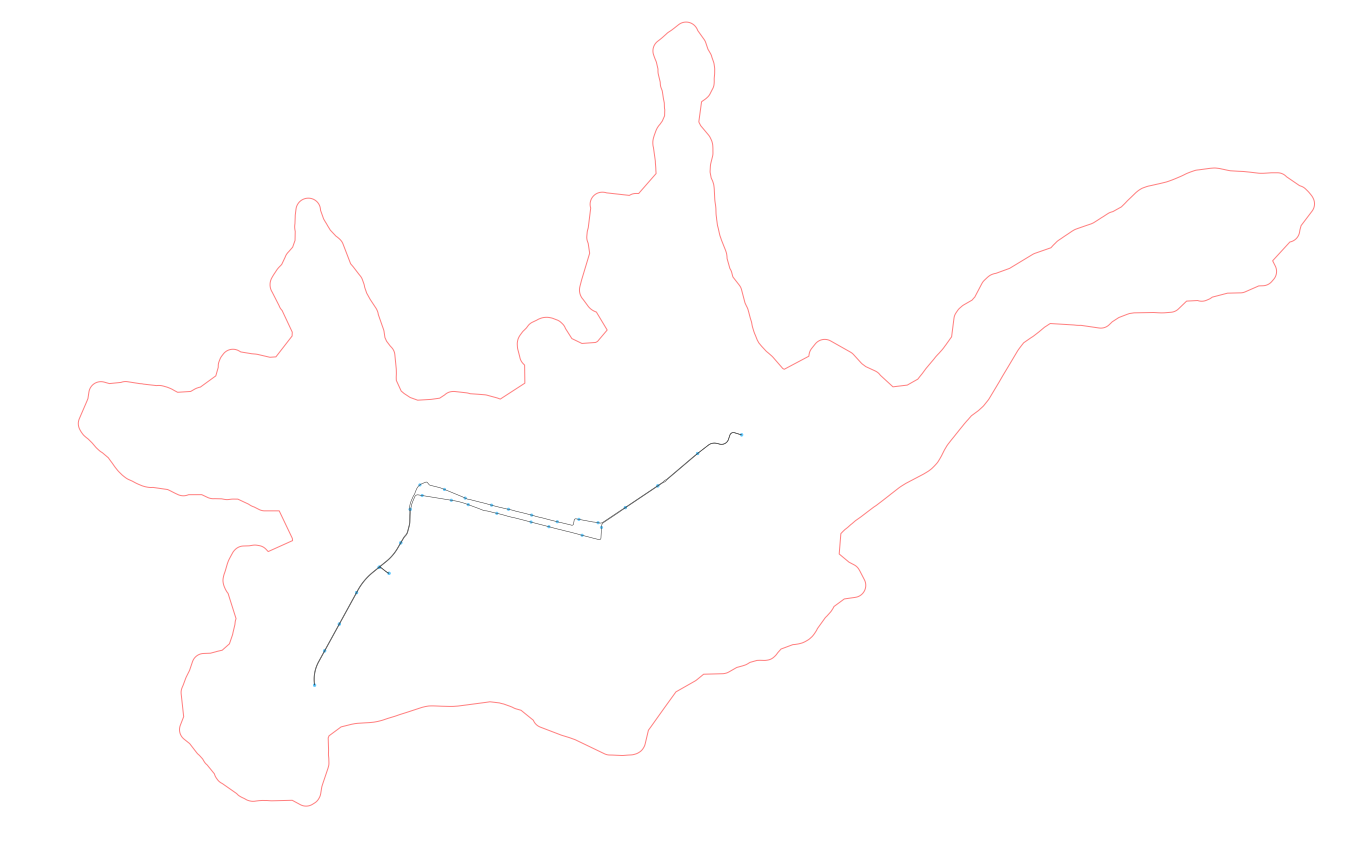

In [10]:
ms.plot_network(tram_network, area)

## Get Tram Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


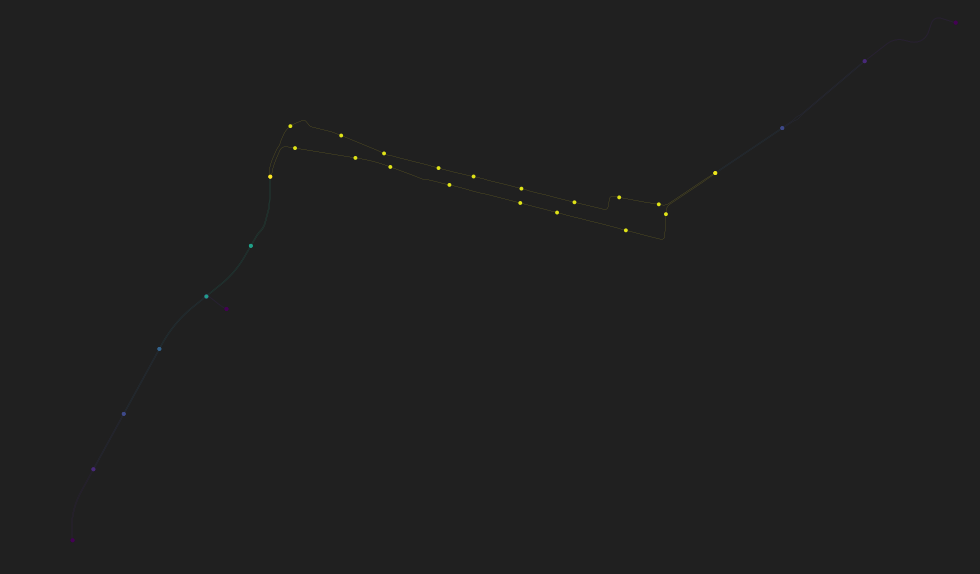

calculating measures for: Random Walk Betweenness


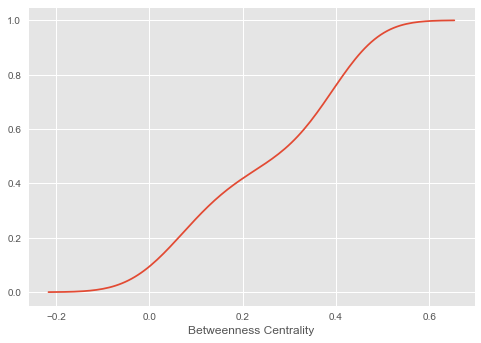

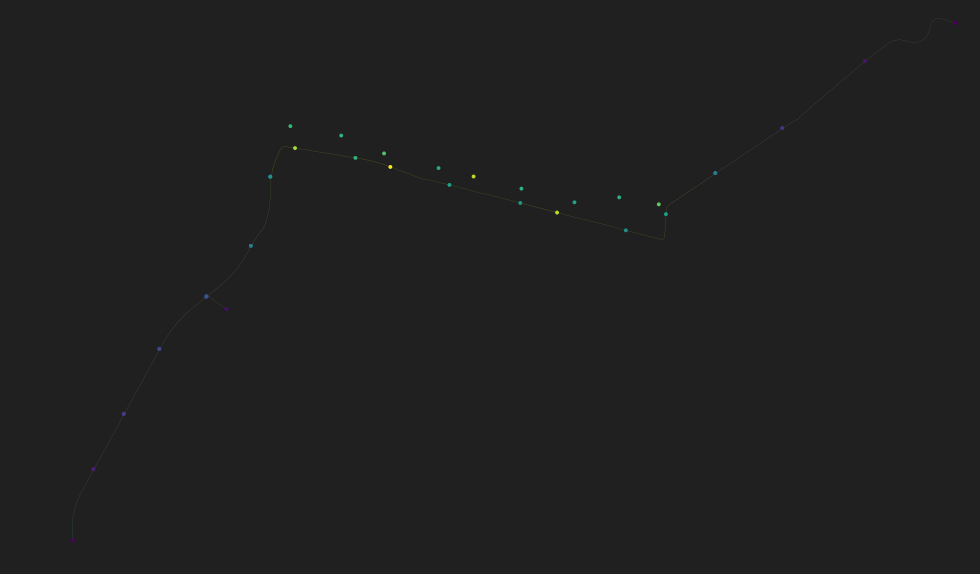

calculating measures for: Information Centrality


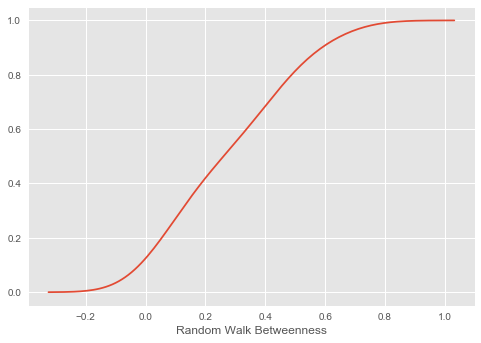

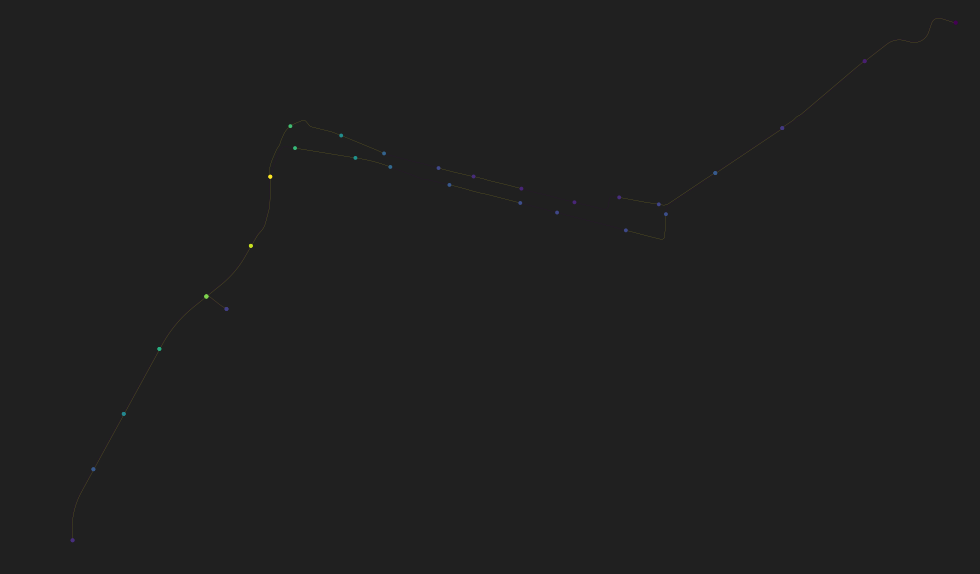

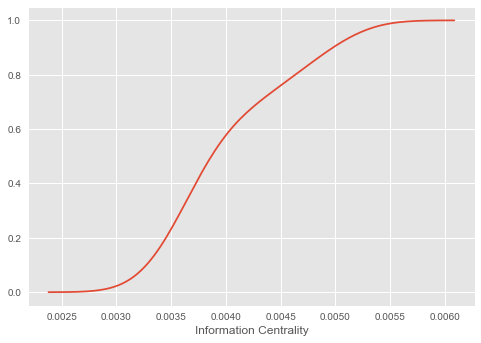

In [225]:
G = ms.network_stats(tram_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('tram_stats'))

## Assign Socio Economic Data to Nodes

voronoi tesselation and weighted area overlay interpolation is used to determine population data at each intersection.

In [8]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()
blocksICV.to_file('{}/blocksICV'.format(output_path))

Ring Self-intersection at or near point 720396.05939999968 9681490.2802000009


Generating voronoi tesselation...


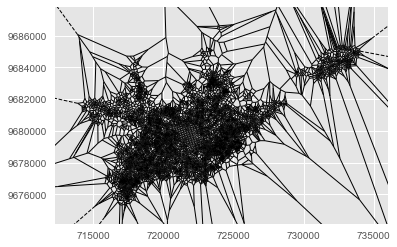

Generating geodataframe...


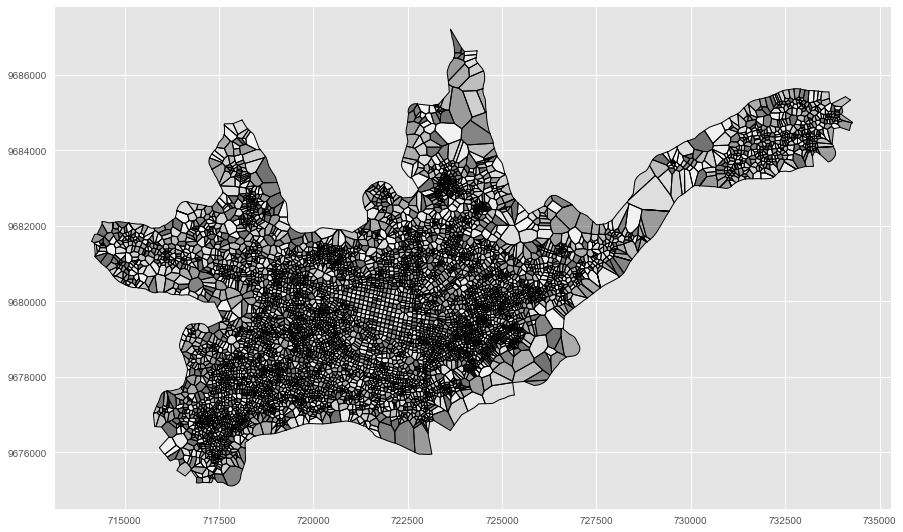

Calculating area overlay...
Calculating values for polygon...
Appending values to geometry...
done!


In [9]:
#map data to intersection
street_network = ms.blocks_to_nodes(street_network, 
                                   blocksICV, 
                                   area, 
                                   crs_utm)
#save to shapefile and graphml
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefileICV'.format('street_network'))

## Create Multiplex

In [10]:
multiplex = ms.create_multiplex(street_network, [bus_network, tram_network], [10,5])

In [16]:
ox.save_graph_shapefile(multiplex, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex'))
ox.save_graphml(multiplex, folder = graphs_folder, filename = '{}/graph'.format('multiplex'))

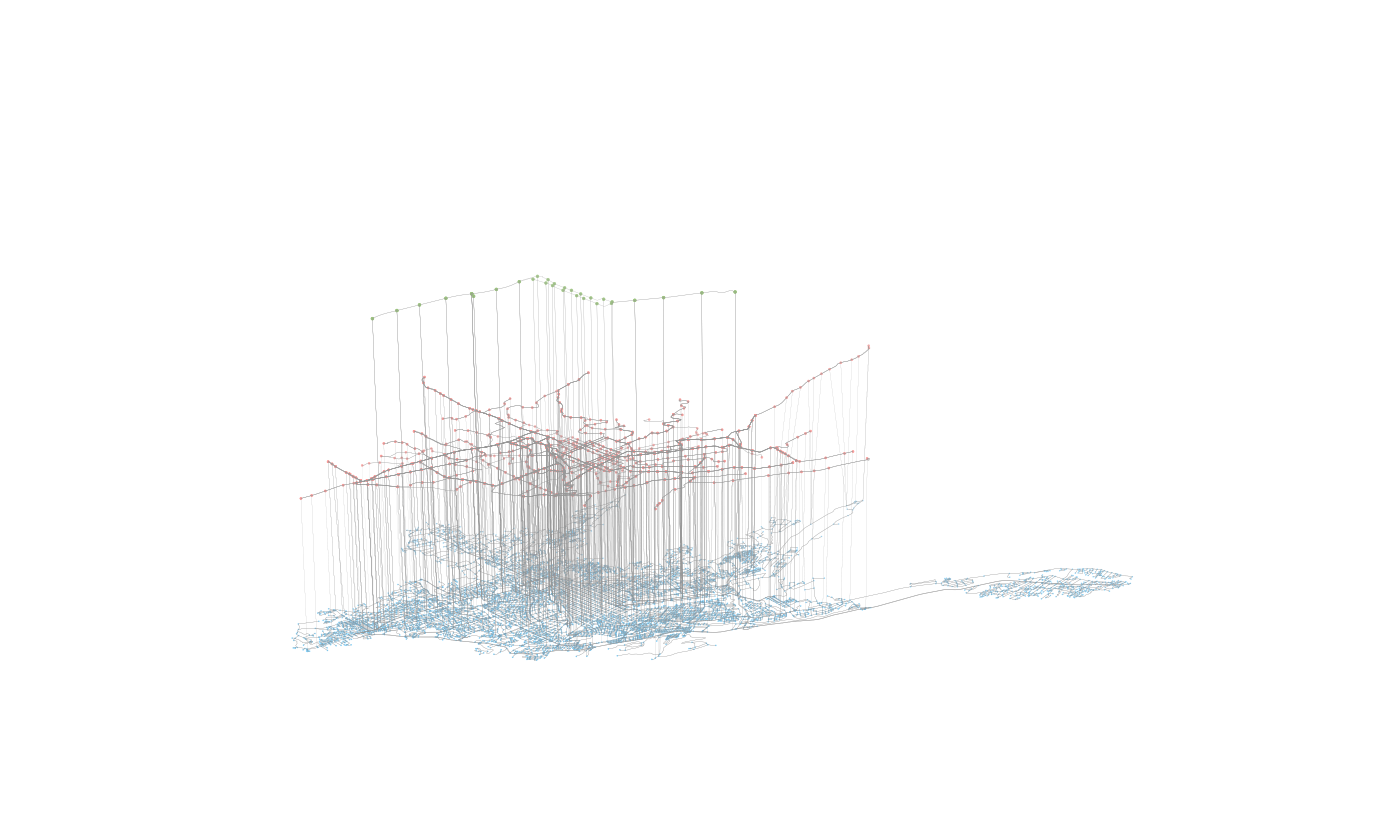

In [14]:
ms.plot_multiplex(multiplex, save = True)

## Get multiplex stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


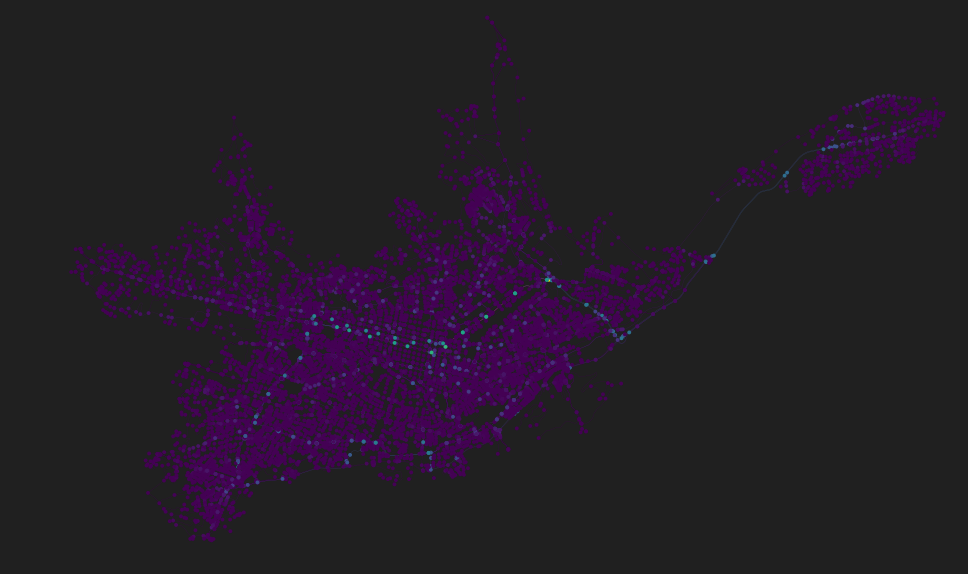

calculating measures for: Random Walk Betweenness


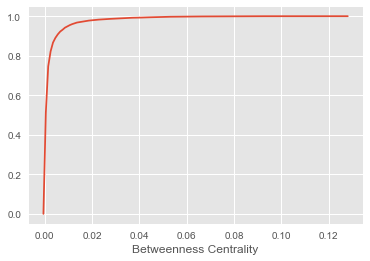

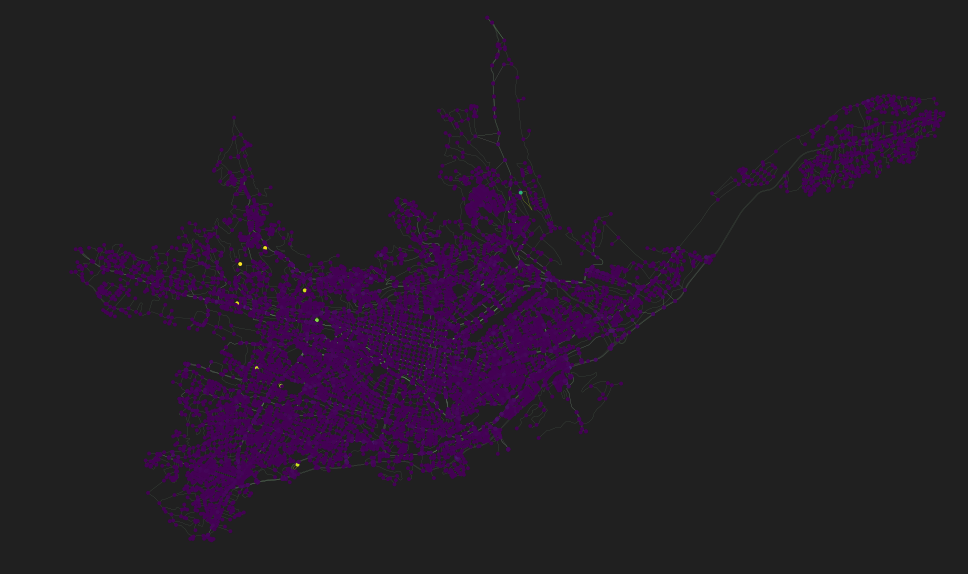

calculating measures for: Information Centrality


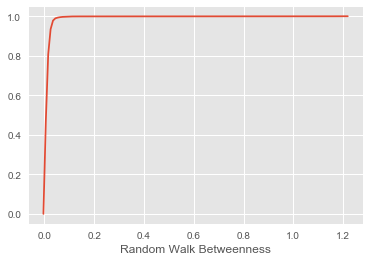

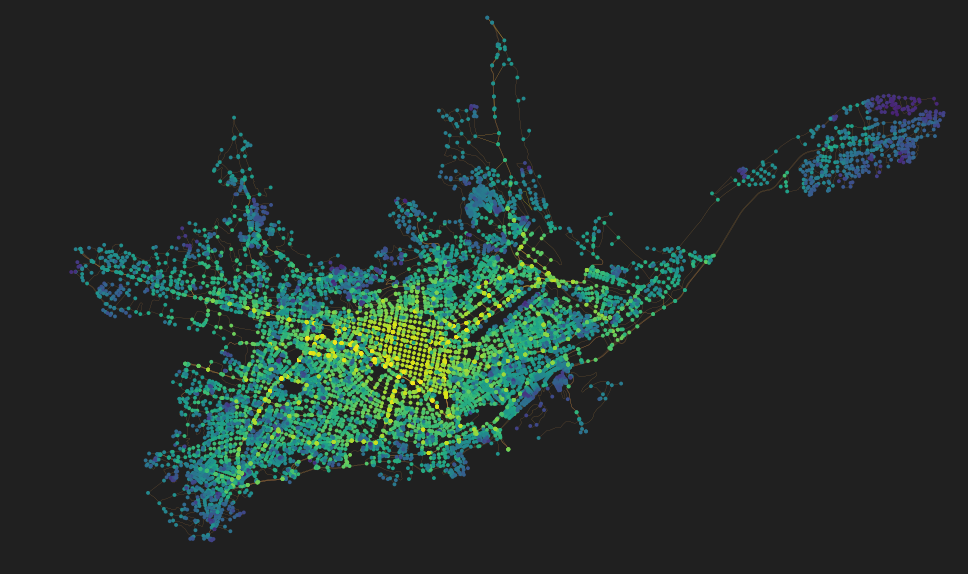

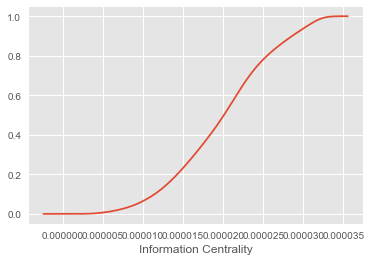

In [10]:
G = ms.network_stats(multiplex, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex_stats'))

## Random Walk Segregation Index

In [ ]:
G = ms.spatial_outreach(multiplex, t=20)

starting calculation for node 321418404-s
calculated spatial outreach for node: 321418404-s in 71.76 seconds
starting calculation for node 321418405-s
calculated spatial outreach for node: 321418405-s in 77.29 seconds
starting calculation for node 611406050-s
calculated spatial outreach for node: 611406050-s in 68.24 seconds
starting calculation for node 611406047-s
calculated spatial outreach for node: 611406047-s in 78.48 seconds
starting calculation for node 1725895464-s
calculated spatial outreach for node: 1725895464-s in 69.41 seconds
starting calculation for node 321418410-s
calculated spatial outreach for node: 321418410-s in 136.33 seconds
starting calculation for node 611406058-s
calculated spatial outreach for node: 611406058-s in 114.17 seconds
starting calculation for node 1725895450-s
calculated spatial outreach for node: 1725895450-s in 121.06 seconds
starting calculation for node 321425856-s
calculated spatial outreach for node: 321425856-s in 162.57 seconds
starting ca

calculated spatial outreach for node: 525278485-s in 134.38 seconds
starting calculation for node 524356271-s
calculated spatial outreach for node: 524356271-s in 136.10 seconds
starting calculation for node 473536082-s
calculated spatial outreach for node: 473536082-s in 119.67 seconds
starting calculation for node 524356296-s
calculated spatial outreach for node: 524356296-s in 114.03 seconds
starting calculation for node 321424817-s
calculated spatial outreach for node: 321424817-s in 103.86 seconds
starting calculation for node 524356268-s
calculated spatial outreach for node: 524356268-s in 123.92 seconds
starting calculation for node 525696997-s
calculated spatial outreach for node: 525696997-s in 86.15 seconds
starting calculation for node 493946923-s
calculated spatial outreach for node: 493946923-s in 93.60 seconds
starting calculation for node 525697008-s
calculated spatial outreach for node: 525697008-s in 86.41 seconds
starting calculation for node 321424843-s
calculated sp

calculated spatial outreach for node: 524356306-s in 59.80 seconds
starting calculation for node 3572060044-s
calculated spatial outreach for node: 3572060044-s in 78.60 seconds
starting calculation for node 577537810-s
calculated spatial outreach for node: 577537810-s in 62.24 seconds
starting calculation for node 343898537-s
calculated spatial outreach for node: 343898537-s in 93.78 seconds
starting calculation for node 525697021-s
calculated spatial outreach for node: 525697021-s in 100.10 seconds
starting calculation for node 620017934-s
calculated spatial outreach for node: 620017934-s in 88.44 seconds
starting calculation for node 3572060043-s
calculated spatial outreach for node: 3572060043-s in 80.23 seconds
starting calculation for node 343899055-s
calculated spatial outreach for node: 343899055-s in 80.89 seconds
starting calculation for node 577263335-s
calculated spatial outreach for node: 577263335-s in 62.38 seconds
starting calculation for node 349333524-s
calculated spa

calculated spatial outreach for node: 3412134058-s in 74.60 seconds
starting calculation for node 347404179-s
calculated spatial outreach for node: 347404179-s in 68.41 seconds
starting calculation for node 539095594-s
calculated spatial outreach for node: 539095594-s in 76.46 seconds
starting calculation for node 999770009-s
calculated spatial outreach for node: 999770009-s in 50.38 seconds
starting calculation for node 742483089-s
calculated spatial outreach for node: 742483089-s in 56.60 seconds
starting calculation for node 347404189-s
calculated spatial outreach for node: 347404189-s in 109.17 seconds
starting calculation for node 577206080-s
calculated spatial outreach for node: 577206080-s in 108.40 seconds
starting calculation for node 3098124222-s
calculated spatial outreach for node: 3098124222-s in 115.59 seconds
starting calculation for node 524331437-s
calculated spatial outreach for node: 524331437-s in 113.79 seconds
starting calculation for node 616712941-s
calculated s

calculated spatial outreach for node: 347652056-s in 131.67 seconds
starting calculation for node 525512790-s
calculated spatial outreach for node: 525512790-s in 109.91 seconds
starting calculation for node 616637704-s
calculated spatial outreach for node: 616637704-s in 65.71 seconds
starting calculation for node 1314751001-s
calculated spatial outreach for node: 1314751001-s in 151.55 seconds
starting calculation for node 347652061-s
calculated spatial outreach for node: 347652061-s in 141.14 seconds
starting calculation for node 473536104-s
calculated spatial outreach for node: 473536104-s in 131.44 seconds
starting calculation for node 624624730-s
calculated spatial outreach for node: 624624730-s in 156.66 seconds
starting calculation for node 347652064-s
calculated spatial outreach for node: 347652064-s in 123.91 seconds
starting calculation for node 525278465-s
calculated spatial outreach for node: 525278465-s in 117.35 seconds
starting calculation for node 473536105-s
calculate

calculated spatial outreach for node: 413678740-s in 127.74 seconds
starting calculation for node 616235235-s
calculated spatial outreach for node: 616235235-s in 138.09 seconds
starting calculation for node 612586171-s
calculated spatial outreach for node: 612586171-s in 152.35 seconds
starting calculation for node 643421376-s
calculated spatial outreach for node: 643421376-s in 113.89 seconds
starting calculation for node 617105637-s
calculated spatial outreach for node: 617105637-s in 106.31 seconds
starting calculation for node 413678745-s
calculated spatial outreach for node: 413678745-s in 176.24 seconds
starting calculation for node 616221042-s
calculated spatial outreach for node: 616221042-s in 177.14 seconds
starting calculation for node 4962835009-s
calculated spatial outreach for node: 4962835009-s in 184.68 seconds
starting calculation for node 4991468333-s
calculated spatial outreach for node: 4991468333-s in 187.44 seconds
starting calculation for node 525411519-s
calcul

calculated spatial outreach for node: 529965599-s in 54.59 seconds
starting calculation for node 1185994540-s
calculated spatial outreach for node: 1185994540-s in 58.69 seconds
starting calculation for node 421919630-s
calculated spatial outreach for node: 421919630-s in 131.44 seconds
starting calculation for node 617037745-s
calculated spatial outreach for node: 617037745-s in 117.97 seconds
starting calculation for node 3068765614-s
calculated spatial outreach for node: 3068765614-s in 142.11 seconds
starting calculation for node 617037769-s


In [ ]:
G

In [49]:
#get street nodes
nodes = list(multiplex.nodes())
street_nodes = ([s for s in nodes if 's' in s])

G_list = []
Av_dist = []
#get nodes within temporal constraint
for i in street_nodes:
    G_i = nx.ego_graph(multiplex, i, radius = 20, center=False, distance = 'weight')
    G_list.append(G_i)
    soi = nx.average_shortest_path_length(G_i, weight = 'distance')
# data['length']


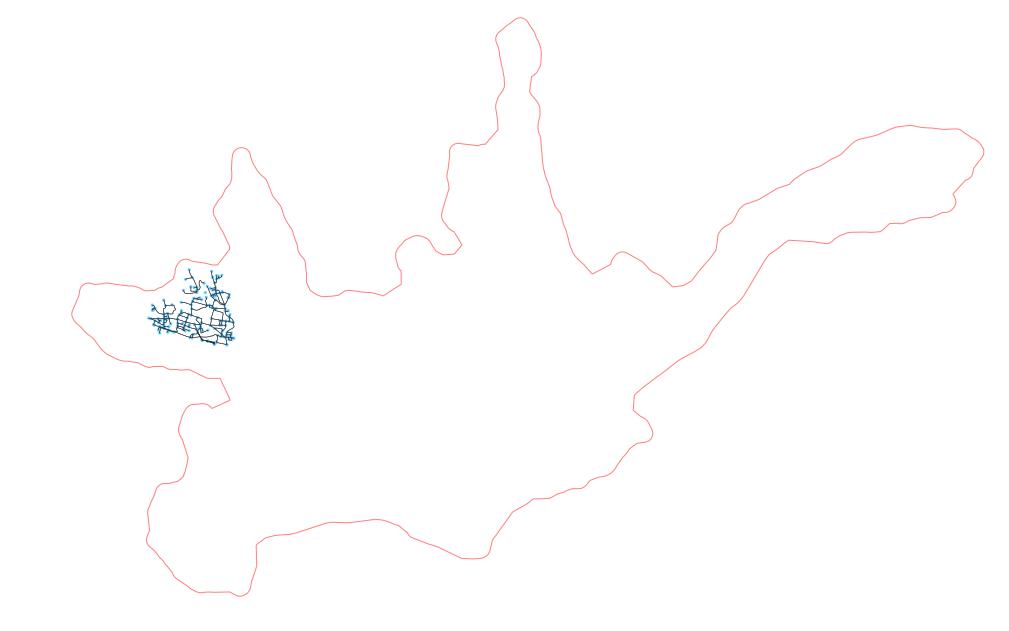

In [91]:
#get street nodes
nodes = list(multiplex.nodes())
street_nodes = ([s for s in nodes if 's' in s])
soi = []
dist = []
#get nodes within temporal constraint
i = street_nodes[100]
G_i = nx.ego_graph(multiplex, i, radius = 20, center=False, distance = 'weight')
son = list(G_i.nodes())
for j in son:
    so_ij = nx.dijkstra_path_length(multiplex, i, j, weight = 'length')
    dist.append(so_ij)
so_index = sum(dist)/len(dist)
soi.append(soi)

# G_list.append(G_i)
# G_i = G_i.to_undirected(reciprocal = False)
# soi = nx.average_shortest_path_length(G_i, weight = 'distance')
# data['length']
# ms.plot_network(G_i, area)

7.0788991817446068

In [35]:
nodes_i = ([s for s in nodes if 's' in s])

['321418404-s', '321418405-s', '611406050-s', '611406047-s', '1725895464-s', '321418410-s', '611406058-s', '1725895450-s', '321425856-s', '321418413-s', '1368603176-s', '2481857562-s', '2481857561-s', '321418416-s', '964653804-s', '620779522-s', '620779535-s', '964653810-s', '321418421-s', '983030209-s', '983030201-s', '738565492-s', '321418423-s', '760204048-s', '2496229587-s', '983030128-s', '321418424-s', '760204072-s', '4076985778-s', '321424620-s', '1334087477-s', '462543771-s', '577206102-s', '321424651-s', '499288996-s', '3839583404-s', '321424687-s', '321424690-s', '419724633-s', '525697125-s', '499289094-s', '643437120-s', '611900875-s', '321424748-s', '878842664-s', '878842465-s', '4249500182-s', '321424755-s', '3058121969-s', '878842480-s', '616756991-s', '616778785-s', '321424770-s', '639836940-s', '964818415-s', '639837073-s', '639837076-s', '321424773-s', '999956008-s', '4504612199-s', '643034573-s', '321424777-s', '3745899744-s', '4083445219-s', '499289032-s', '321424779

0.004601932274640244
0.004986356101631345
0.0052365152758813375
0.005488738821224092
0.00569367919295258
0.005968779238060014
0.006161428488756555
0.006546680996215465
0.0065751774177768
0.006575177417776803
0.0066889620758872285
0.00674876018882249
0.006665184387568703
0.004301330735829192
0.005079098208241045
0.004410441612919716
0.004430074650592119
0.004069477837389521
0.003930871734163677
0.0037878448690894626
0.0035621437102115175
0.005636481808884453
0.0043124813580731084
0.004182994920450218
0.006487417349758945
0.006749599200360199
0.00675523414994994
0.004455918484876616
0.004704694035421735
0.004275795359084657
0.0042238580596729676
0.004215617214573682
0.00613916931159446
0.00548395865592614
0.0065751774177768
0.006416425006465248
0.006575394461236389
0.00548395865592614
0.00613916931159446
0.006575177417776803
0.006416425006465248
0.006575394461236387
0.00498636017185036
0.004601932274640244
0.005488753616340954
0.0052365152758813375
0.005968843391393676
0.0056936791929525

In [192]:
for u,v,k in G.edges(keys=True):
    print (u,v,k)

0 24 0
1 0 18
1 25 0
2 1 17
2 26 0
3 2 16
3 27 0
4 3 15
4 21 0
4 23 0
4 28 0
5 4 14
5 29 0
6 15 7
7 11 10
8 17 3
8 33 0
9 12 1
9 34 0
10 9 0
10 35 0
11 13 11
12 8 2
12 36 0
13 14 12
14 5 13
14 38 0
15 16 8
16 7 9
17 19 4
18 6 6
19 18 5
20 21 19
20 22 0
21 4 0
21 23 0
21 28 0
22 20 0
23 22 20
23 4 0
23 21 0
23 28 0
24 25 21
24 0 0
25 26 22
25 1 0
26 27 23
26 2 0
27 28 24
27 3 0
28 29 25
28 4 0
28 21 0
28 23 0
29 38 26
29 5 0
30 40 34
31 32 28
32 39 29
33 36 36
33 8 0
34 35 38
34 9 0
35 10 0
36 34 37
36 12 0
37 42 31
38 31 27
38 14 0
39 37 30
40 33 35
41 30 33
42 41 32
